In [10]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial.qhull as qhull
import matplotlib.tri as mtri
import cmocean
%matplotlib inline

### oen with intake

In [ ]:
import intake
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
eerie_cat
# %%
eerie_dkrz=eerie_cat["dkrz"]
eerie_dkrz_disk=eerie_dkrz["disk"]
cat=eerie_dkrz_disk["model-output"]

ds = cat["icon-esm-er.eerie-control-1950.ocean.native.2d_daily_mean"].to_dask()
ds_tgrid = cat["icon-esm-er.eerie-control-1950.ocean.native.2d_grid"].to_dask()

### open from download

In [4]:
path_2_data = '/Users/mepke/python/tapgfd/data/swift.dkrz.de/tapgfd_workshop/'
ds_tgrid = xr.open_dataset(f'{path_2_data}icon-esm-er.eerie-control-1950.ocean.native.2d_grid_minimal.nc')

In [5]:
ds_tgrid

<xarray.Dataset>
Dimensions:         (vertex: 7487687, cell: 14886338, nv: 3)
Coordinates:
    vlon            (vertex) float64 ...
    vlat            (vertex) float64 ...
    clon            (cell) float64 ...
    clat            (cell) float64 ...
Dimensions without coordinates: vertex, cell, nv
Data variables:
    vertex_of_cell  (nv, cell) float64 ...
Attributes: (12/43)
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    NCO:                      netCDF Operators version 4.7.5 (Homepage = http...
    boundary_depth_index:     0
    centre:                   252
    coverage:                 ocean only
    crs_id:                   urn:ogc:def:cs:EPSG:6.0:6422
    ...                       ...
    subcentre:                1
    symmetry:                 along equator
    title:                    ICON grid description
    topography:               modified SRTM30
    user_name:                Rene Redler (m300083)
    uuidOfHGrid:              375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b

In [6]:
ds = xr.open_dataset(f'{path_2_data}icon-esm-er.eerie-control-1950.ocean.native.2d_daily_mean_snapshot.nc')
ds

<xarray.Dataset>
Dimensions:                              (ncells: 14886338, depth: 1, lev: 1)
Coordinates:
  * depth                                (depth) float64 1.0
    lat                                  (ncells) float64 ...
  * lev                                  (lev) float64 0.0
    lon                                  (ncells) float64 ...
    time                                 datetime64[ns] ...
Dimensions without coordinates: ncells
Data variables:
    Wind_Speed_10m                       (ncells) float32 ...
    atmos_fluxes_FrshFlux_Evaporation    (ncells) float32 ...
    atmos_fluxes_FrshFlux_Precipitation  (ncells) float32 ...
    cell_sea_land_mask                   (ncells) int32 ...
    mlotst10                             (ncells) float32 ...
    sea_level_pressure                   (ncells) float32 ...
    so                                   (depth, ncells) float32 ...
    ssh                                  (ncells) float32 ...
    to                                   (depth, ncells) float32 ...
    u                                    (depth, ncells) float32 ...
    v                                    (depth, ncells) float32 ...
Attributes: (12/34)
    CDI:                      Climate Data Interface version 2.2.0 (https://m...
    Conventions:              CF-1.6
    DOKU_License:             CC BY 4.0
    DOKU_Name:                EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:             Putrasahan, D.; Kröger, J.; Wachsmann, F.
    DOKU_responsible_person:  Fabian Wachsmann
    ...                       ...
    source_type:              AOGCM
    time_max:                 28401119
    time_min:                 27351359
    time_reduction:           mean
    title:                    ICON simulation
    uuidOfHGrid:              375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b

In [7]:
# gridICON = xr.open_dataset('/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc')
# dataICON = xr.open_dataset('/work/bm1235/k203123/experiments/ngc2009/run_20201031T000000-20201114T235920/ngc2009_oce_0-200m_3h_inst_1_20201031T000000Z.nc')

gridICON = ds_tgrid
dataICON = ds

In [18]:
data_sample_icon.shape


(14886338,)

In [9]:
#icon cells
model_lon_icon   = gridICON.clon.values*180./np.pi
model_lat_icon   = gridICON.clat.values*180./np.pi
# data_sample_icon = dataICON.to[0,0,:].values # to (time, depth, ncells) float32 ...
data_sample_icon = dataICON.to.squeeze().values # to (time, depth, ncells) float32 ...

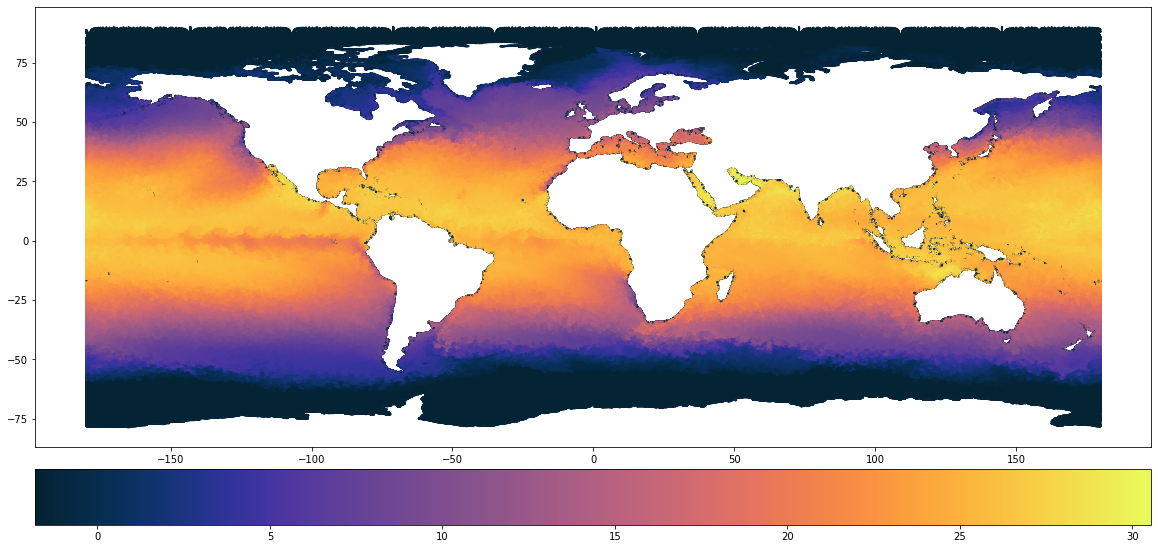

In [11]:
plt.figure(figsize=(20,10))
plt.scatter(model_lon_icon, model_lat_icon, s=1 , c=data_sample_icon, cmap=cmocean.cm.thermal)
plt.colorbar(orientation='horizontal', pad=0.04)

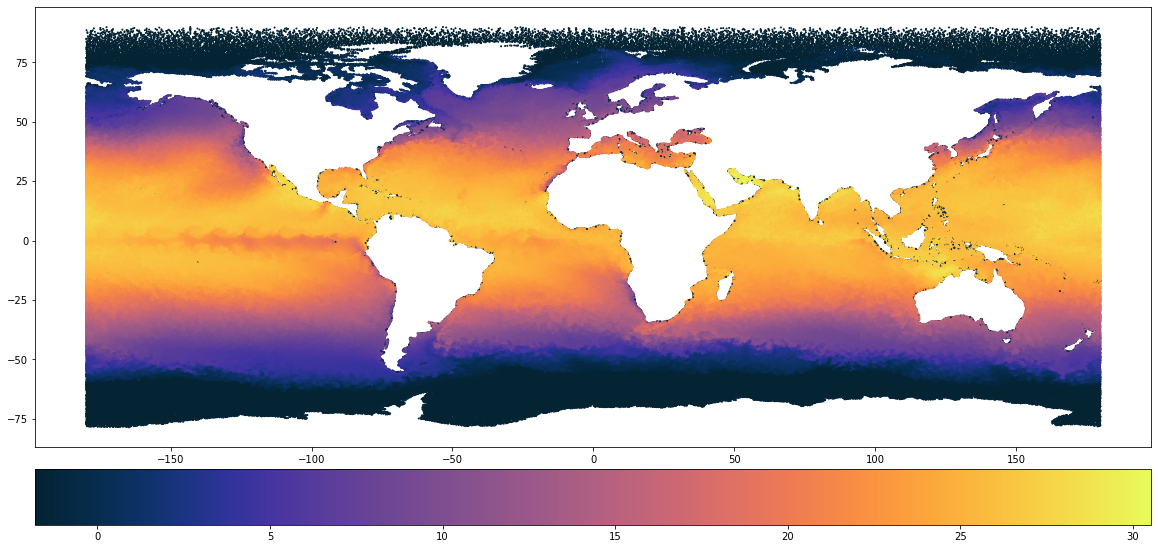

In [26]:
#icon
sstep = 14
plt.figure(figsize=(20,10))
plt.scatter(model_lon_icon[::sstep], model_lat_icon[::sstep], s=1 , c=data_sample_icon[::sstep], cmap=cmocean.cm.thermal)
plt.colorbar(orientation='horizontal', pad=0.04)

In [20]:
left   = -90
right  = -10
bottom = 0
top    = 26

regionICON = (model_lon_icon < right) & (model_lon_icon>left) & (model_lat_icon > bottom) & (model_lat_icon < top)


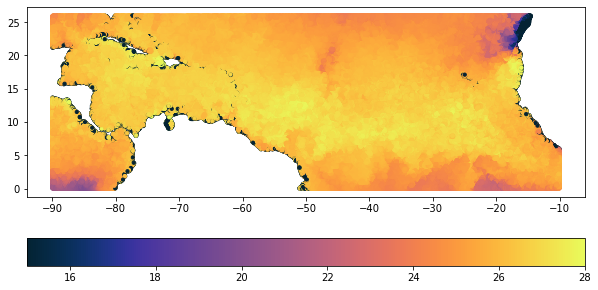

In [28]:
sstep = 1
plt.figure(figsize=(10,5))
plt.scatter(model_lon_icon[regionICON][::sstep], 
            model_lat_icon[regionICON][::sstep], 
            s=10 , c=data_sample_icon[regionICON][::sstep], cmap=cmocean.cm.thermal, vmin=15, vmax=28)
plt.colorbar(orientation='horizontal')

In [29]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

/Users/mepke/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mepke/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mepke/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


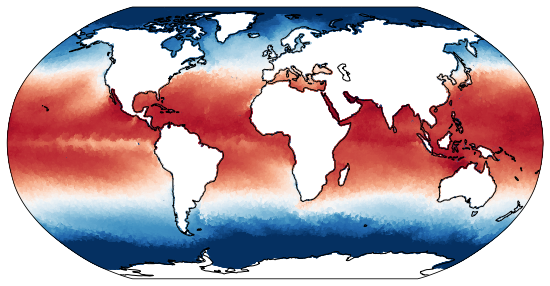

In [30]:
#icon
sstep = 14
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
ax.scatter(model_lon_icon[::sstep], model_lat_icon[::sstep], s=1 , c=data_sample_icon[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

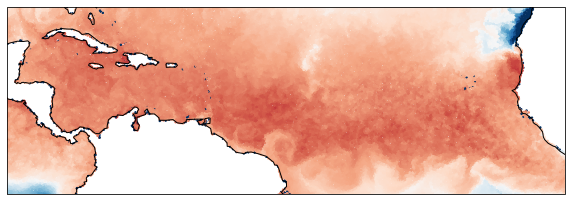

In [31]:
#icon
sstep = 14
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
ax.scatter(model_lon_icon[::sstep], model_lat_icon[::sstep], s=2 , c=data_sample_icon[::sstep], 
           vmin=17, vmax=30,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

# simple interpolation to regular grid

In [32]:
# alternative input could be grid from observation
lon = np.linspace(-70, -60, 80)
lat = np.linspace(30, 40, 80)

lon = np.linspace(left, right, 4*80)
lat = np.linspace(bottom, top, 4*80)

lon2, lat2 = np.meshgrid(lon, lat)

In [33]:
points_icon = np.vstack((model_lon_icon, model_lat_icon)).T
points_icon

array([[ 73.        ,  72.14153539],
       [ 73.11610713,  72.11842828],
       [ 73.        ,  72.17353504],
       ...,
       [ 76.49297292, -45.17171677],
       [ 76.54481611, -45.23138792],
       [ 76.4503828 , -45.23383705]])

In [34]:
%%time
#fastest
nn_interpolation_icon = NearestNDInterpolator(points_icon, data_sample_icon)
#linear
# nn_interpolation_icon = LinearNDInterpolator(points_icon, data_sample_icon)
#bilinear
# nn_interpolation_icon = CloughTocher2DInterpolator(points_icon, data_sample_icon)

CPU times: user 3.73 s, sys: 221 ms, total: 3.95 s
Wall time: 3.98 s


In [35]:
%%time
interpolated_nn_icon = nn_interpolation_icon((lon2, lat2))

CPU times: user 208 ms, sys: 2.41 ms, total: 210 ms
Wall time: 210 ms


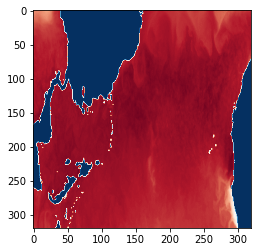

In [36]:
plt.imshow(interpolated_nn_icon, cmap=cm.RdBu_r)

In [37]:
icon_interpolated_global = interpolated_nn_icon

/Users/mepke/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mepke/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mepke/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/mepke/minico

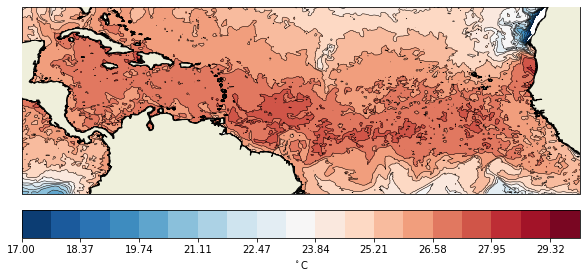

In [38]:
	
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.contourf(lon2, lat2, icon_interpolated_global, 
           levels = np.linspace(17,30,20),
           #levels = np.linspace(-2,30,27),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
ax.contour(lon2, lat2, icon_interpolated_global, 
           levels = np.linspace(17,30,20),
           #levels = np.linspace(-2,30,27),
           transform=ccrs.PlateCarree(), zorder=10, colors='k', linewidths=0.5)
ax.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
#ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')